In [1]:
import jax
import jax.numpy as jnp
from jax import random, lax

import matplotlib.pyplot as plt

In [2]:
RESX = RESY = 25
numel = RESX * RESY
RADIUS = 5
Rk = 2*RADIUS + 1

xm, ym = jnp.meshgrid(jnp.linspace(-1, 1, Rk), jnp.linspace(-1, 1, Rk))
rm = jnp.sqrt(xm ** 2 + ym ** 2)
exp_rm = jnp.exp(-rm ** 2)
condition = rm < 1.
null = jnp.zeros_like(rm)
rm = jnp.expand_dims(jnp.where(condition, exp_rm, null), [0, -1])

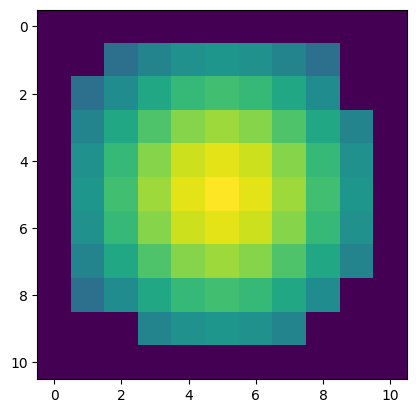

In [3]:
plt.imshow(rm[0, :, :, 0])

In [4]:
seed = 1234
key = random.PRNGKey(seed)

nearest_neighbours = 1 + random.uniform(key, (Rk, Rk, RESX, RESY))
nearest_neighbours = nearest_neighbours.at[RADIUS, RADIUS, :, :].set(0)
nearest_neighbours = nearest_neighbours.reshape(1, -1, RESX, RESY)
nearest_neighbours.shape


(1, 121, 25, 25)

In [5]:
def initGrid(RES, key):
    shape = RES
    key_s, key_b = random.split(key)
    BETA = 1
    
    rand_s = random.bernoulli(key_s, p=0.5, shape=(1, 1, shape[0], shape[1])) * 2. - 1.
    rand_tr = jnp.zeros((1, 1, shape[0], shape[1]), dtype=jnp.float32)
    rand_b = jnp.ones((1, 1, shape[0], shape[1]), dtype=jnp.float32) * BETA
    
    return jnp.concatenate([rand_s, rand_tr, rand_b], axis=1)

x = initGrid((RESX, RESY), key)

In [6]:
s = x[:, [0], ...]
tr = x[:, [1], ...]
b = x[:, [-1], ...]
shape = s.shape[1:]

s_pad = jnp.pad(s, [(0, 0), (0, 0), (RADIUS, RADIUS), (RADIUS, RADIUS)], mode='wrap')
s_pad.shape

(1, 1, 35, 35)

In [7]:
def jax_unfold(arr, k_size):
    arr_unf = jax.lax.conv_general_dilated_patches(
        lhs=arr,
        filter_shape=(k_size,k_size),
        window_strides=(1,1),
        padding = 'VALID',
        dimension_numbers  = ('NCWH', 'WHIO', 'NCWH'))
    return arr_unf

In [8]:
s_pad_unf = jax_unfold(s_pad, Rk)
s_pad_unf.shape

(1, 121, 25, 25)

In [9]:
(s_pad_unf * nearest_neighbours).shape

(1, 121, 25, 25)

In [10]:
nearest_neighbours.shape

(1, 121, 25, 25)

In [11]:
s = x[:, [0], ...]
tr = x[:, [1], ...]
b = x[:, [-1], ...]
shape = s.shape
Rk = RADIUS

s_pad = jnp.pad(s, [(0, 0), (0, 0), (Rk, Rk), (Rk, Rk)], mode='wrap')

sJs = 2 * jax_unfold(s, 1) * (jax_unfold(s_pad, 2 * Rk + 1) * nearest_neighbours)
delta_e = sJs.sum(axis=1).reshape(*shape)
E = (-0.5 * delta_e)

In [12]:
make_obv = True

J_adapt = False
adapt_lr = 0.5
alpha = 0.9
h = 0.01
eps = 0.01
max_weight = 4.
trace_memory = 0.995

if make_obv:
    ### OBSERVATIONS ###
    e = E.mean() / 4.
    e2 = e**2

    m = s.mean()
    m2 = m ** 2

    obvs = jnp.stack([e, e2, m, m2], axis=0)
#####################

definite_flip = delta_e <= 0
p = jnp.exp(-delta_e * b)
p = jnp.where(definite_flip, jnp.ones_like(s), p)

key, subkey = random.split(key)
flip_rand = random.uniform(subkey, shape)

key, subkey = random.split(key)
dropout_mask = (random.uniform(subkey, shape) > 0.5)
flip = -2. * jnp.logical_and(flip_rand < p, dropout_mask) + 1

key, subkey = random.split(key)
rng_adapt = random.uniform(subkey, (1, ))
adapt_thresh = 0.5

if J_adapt and rng_adapt > adapt_thresh:
    s_i = jax_unfold(tr, 1)
    
    tr_pad = jnp.pad(tr, [(0, 0), (0, 0), (Rk, Rk), (Rk, Rk)], mode='wrap')
    s_j = jax_unfold(tr_pad, 2*Rk+1)

    growth = h / Rk * (1 - s_i.abs()) * (1 - s_j.abs())  # correlate
    # growth = self.h / Rk
    # decay = self.eps * (s_j.mean(dim=1, keepdim=True) * s_i)  # decorrelate if mag.
    decay = eps * (s_j * s_i)  # decorrelate if mag.
    dJ = (growth - decay)  # * self.rm.reshape(1, -1, 1)

    key, subkey = random.split(key)
    conn_shape = (1, int(jnp.product(shape)), 2*Rk+1, 2*Rk+1)
    adapt_mask = random.uniform(subkey, conn_shape) > 0.5     
    
    new_J = nearest_neighbours + \
            dJ * adapt_lr * adapt_mask # stochastic dJ
    new_J[:, :, Rk, Rk] = 0.  # set center pixel to 0.

    # set corners to 0
    new_J[:, :, -1, -1] = 0.
    new_J[:, :, -1, 0] = 0.
    new_J[:, :, 0, -1] = 0.
    new_J[:, :, 0, 0] = 0.

    nearest_neighbours = ((1 - alpha) * nearest_neighbours + alpha * new_J)

tr = trace_memory * tr + (1 - trace_memory) * s

if make_obv:
    x, obvs = jnp.concatenate([(s * flip), tr, b], axis=1), obvs
else:
    x = jnp.concatenate([(s * flip), tr, b], axis=1)

In [3]:
from JAX_isingCA_local_connectivity_xi import isingCA
seed = 1234
key = random.PRNGKey(seed)
RADIUS = 5
ca = isingCA(key, (100, 100), RADIUS=RADIUS)
state = ca.initGrid()

# %timeit ca.forward(state)

In [6]:
(ca.rule.nearest_neighbours).sum(axis=1)[0].shape

(100, 100)

In [31]:
forward_jit = jax.jit(ca.forward)
%timeit forward_jit(state)

87.1 µs ± 634 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [32]:
from isingCA_local_connectivity_xi import isingCA
ca = isingCA(RES=(100, 100), RADIUS=RADIUS)
state = ca.initGrid()

%timeit ca.forward(state)

435 µs ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
